**Real vs. Fake Faces Image Classification**

**Convolutional Neural Network (CNN)**

**HaeLee Kim**


Import Libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
from itertools import cycle
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, f1_score, classification_report

Load the Data

In [ ]:
from google.colab import drive
import sys

drive.mount('/content/drive', force_remount=True)
abspath_curr = '/content/drive/My Drive/Colab Notebooks/Statistical Deep Learning/Data/'

Mounted at /content/drive


In [ ]:
label_df = pd.read_csv(abspath_curr + 'data.csv')
print(label_df.head())

  images_id label
0    real_1  real
1   real_10  real
2  real_100  real
3  real_101  real
4  real_102  real


In [ ]:
train_fake_dir = os.path.dirname(abspath_curr + '/fake/')
train_real_dir = os.path.dirname(abspath_curr + '/real/')

fake_image_files = os.listdir(train_fake_dir)
real_image_files = os.listdir(train_real_dir)

print(f"Number of fake images: {len(fake_image_files)}")
print(f"Number of real images: {len(real_image_files)}")

Number of fake images: 700
Number of real images: 589


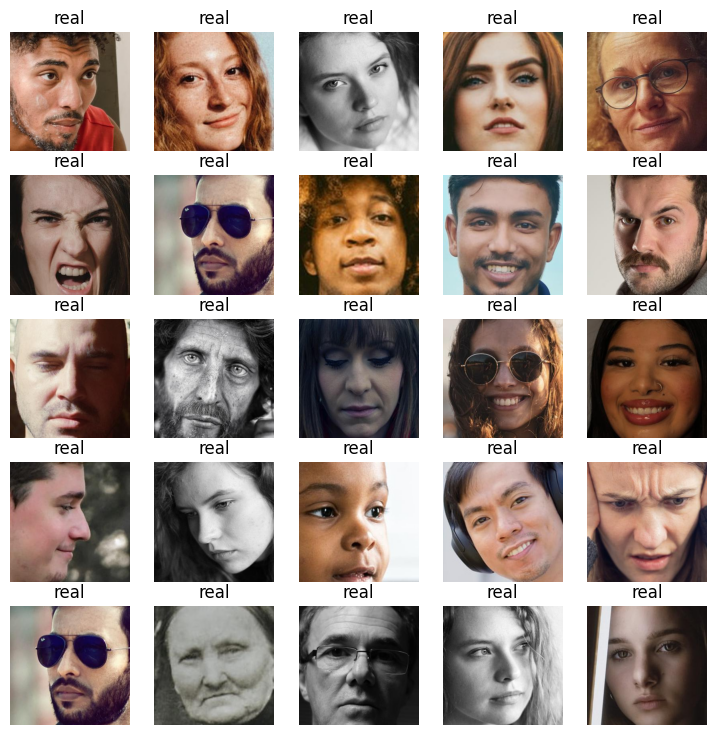

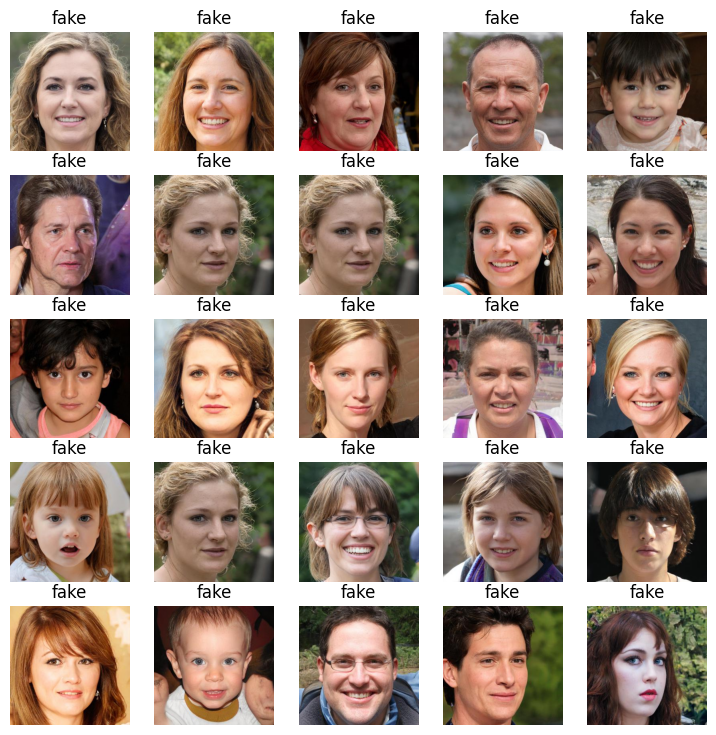

In [ ]:
def image_plot(train_dir, image_files):
    plt.figure(figsize=(9, 9))
    for i in range(5 * 5):
        pic_index = np.random.randint(0, len(image_files))
        img_path = os.path.join(train_dir, image_files[pic_index])
        img = Image.open(img_path)
        plt.subplot(5, 5, i + 1)
        plt.title('real' if 'real' in train_dir else 'fake')
        plt.axis('off')
        plt.imshow(img)
    plt.show()

image_plot(train_real_dir, os.listdir(train_real_dir))
image_plot(train_fake_dir, os.listdir(train_fake_dir))


Combine & Split the Data

In [ ]:
# Load fake and real data
fake_images = [os.path.join(train_fake_dir, filename) for filename in fake_image_files]
real_images = [os.path.join(train_real_dir, filename) for filename in real_image_files]

fake_labels = [0] * len(fake_images)
real_labels = [1] * len(real_images)


# Combine / Suffle the datasets
combined_images = fake_images + real_images
combined_labels = fake_labels + real_labels

combined_data = list(zip(combined_images, combined_labels))
random.shuffle(combined_data)

# Split into train and test sets / Separate images and labels of train and test sets
split_ratio = 0.8
split_index = int(split_ratio * len(combined_data))
train_data = combined_data[:split_index]
test_data = combined_data[split_index:]

train_images, train_labels = zip(*train_data)
test_images, test_labels = zip(*test_data)

Preprocess the Data

In [ ]:
def preprocess_image(image_path):
    image = load_img(image_path, target_size=(300,300))
    image = img_to_array(image)
    image /= 255  # Normalize pixel values to the range [0, 1]
    return image

train_images = [preprocess_image(image_path) for image_path in train_images]
train_images = np.array(train_images)
train_labels = np.array(train_labels)

test_images = [preprocess_image(image_path) for image_path in test_images]
test_images = np.array(test_images)
test_labels = np.array(test_labels)

X_train = train_images
y_train = train_labels
X_test = test_images
y_test = test_labels


Generate the Convolutional Neural Network(CNN)

In [ ]:
num_classes = 2  # fake and real

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))  # Reduced to 128 neurons
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 300, 300, 32)      896       
                                                                 
 activation (Activation)     (None, 300, 300, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 150, 150, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 150, 150, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 64)      18496     
                                                                 
 activation_1 (Activation)   (None, 150, 150, 64)      0         
                                                        

Train & Test the Model

In [ ]:
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

# Compile the model
opt = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Data augmentation
datagen = ImageDataGenerator(rotation_range=40, width_shift_range=0.2,
                             height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                             horizontal_flip=True, fill_mode='nearest')

# Fit the model
batch_size = 32
epochs = 10
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                    validation_data=(X_test, y_test), verbose=1)


Epoch 1/10
33/33 [==============================] - 210s 6s/step - loss: 0.6539 - accuracy: 0.8070 - val_loss: 0.2441 - val_accuracy: 0.9845
Epoch 2/10
33/33 [==============================] - 203s 6s/step - loss: 0.1378 - accuracy: 0.9564 - val_loss: 0.2083 - val_accuracy: 0.9457
Epoch 3/10
33/33 [==============================] - 196s 6s/step - loss: 0.1042 - accuracy: 0.9622 - val_loss: 0.1715 - val_accuracy: 0.9767
Epoch 4/10
33/33 [==============================] - 210s 6s/step - loss: 0.1105 - accuracy: 0.9612 - val_loss: 0.1186 - val_accuracy: 0.9922
Epoch 5/10
33/33 [==============================] - 205s 6s/step - loss: 0.1007 - accuracy: 0.9593 - val_loss: 0.1432 - val_accuracy: 0.9922
Epoch 6/10
33/33 [==============================] - 195s 6s/step - loss: 0.0702 - accuracy: 0.9777 - val_loss: 0.0871 - val_accuracy: 0.9922
Epoch 7/10
33/33 [==============================] - 211s 6s/step - loss: 0.0316 - accuracy: 0.9913 - val_loss: 0.0591 - val_accuracy: 0.9922
Epoch 8/10
33

In [ ]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

y_test = y_test.flatten()
y_pred = y_pred.flatten()

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# F1 score
f1 = f1_score(y_test, y_pred, average='binary')
print(f'F1 Score: {f1:.4f}')

# report = classification_report(y_test, y_pred, target_names=['fake', 'real'])
# print(report)


9/9 [==============================] - 11s 1s/step
Accuracy: 0.9961
F1 Score: 0.9961


Plot the Training/Testing Accuracy & Loss

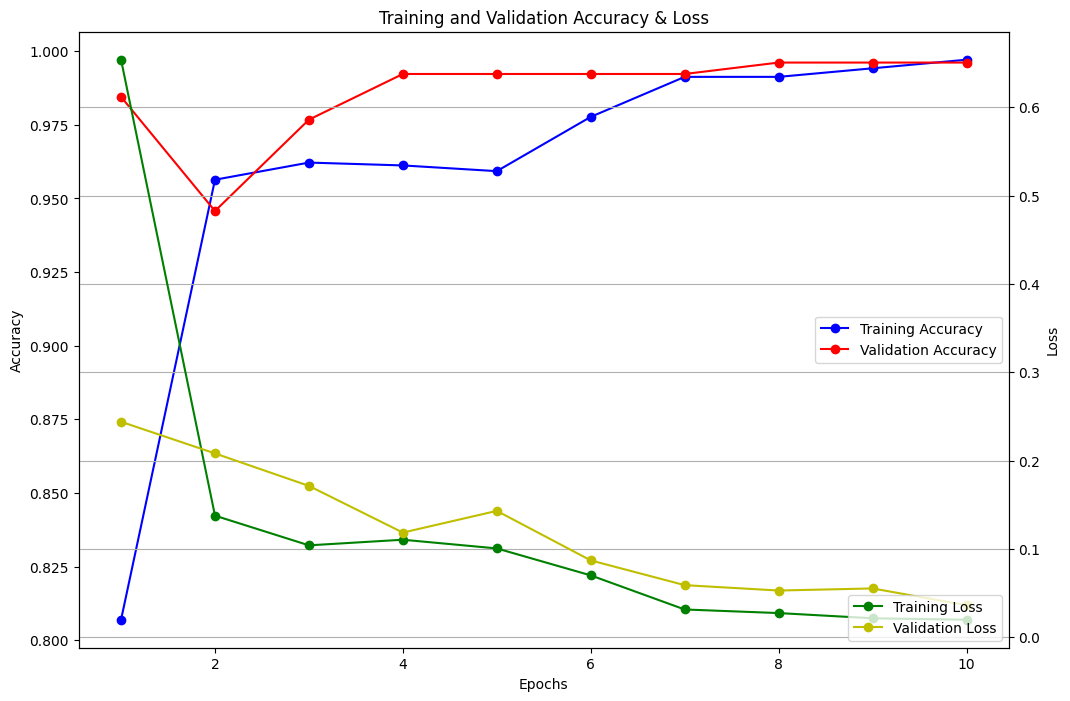

In [ ]:
training_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(1, len(training_acc) + 1)

plt.figure(figsize=(12, 8))

# Plot accuracies
plt.plot(epochs, training_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, validation_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy & Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='center right')

# Plot losses
plt.twinx()  # Create a twin y-axis
plt.plot(epochs, training_loss, 'go-', label='Training Loss')
plt.plot(epochs, validation_loss, 'yo-', label='Validation Loss')
plt.ylabel('Loss')
plt.legend(loc='lower right')

plt.grid()
plt.show()

In [ ]:
training_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']

# Lists of training and validation accuracy
print("Training Accuracy:", training_acc)
print("Validation Accuracy:", validation_acc)

Training Accuracy: [0.8069835305213928, 0.9563530683517456, 0.9621726274490356, 0.9612027406692505, 0.9592628479003906, 0.9776915907859802, 0.9912706017494202, 0.9912706017494202, 0.9941803812980652, 0.997090220451355]
Validation Accuracy: [0.9844961166381836, 0.9457364082336426, 0.9767441749572754, 0.9922480583190918, 0.9922480583190918, 0.9922480583190918, 0.9922480583190918, 0.9961240291595459, 0.9961240291595459, 0.9961240291595459]


**Concluision**

1. Training Accuracy:
Started around 80.7% in the first epoch and steadily improved to nearly 99.7% in the last epoch.
Indicates effective learning from the training data.

2. Validation Accuracy:
Began at 98.4% in the first epoch and stabilized at around 99.2% in later epochs.
Showed robust generalization to unseen data.

3. Overall Model Performance:
Model effectively learnt during training and achieved high accuracy in both training and validation datasets.

4. Limitation:
Model’s impressive accuracy and generalization could be attributed to the limited dataset.
A larger and more diverse dataset might provide a better understanding of the model’s performance.
